In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

In [1]:
# # RetinaGuard: AI-Powered Diabetic Retinopathy Detection
# ---
# **Purpose**: Detect and grade Diabetic Retinopathy (DR) from retinal fundus images (grades 0–4) for Algerian clinics with limited specialist access.  
# **Dataset**: APTOS 2019 Blindness Detection (Kaggle).  
# **Approach**: Lightweight EfficientNet-B0 with CORAL loss for ordinal regression, Grad-CAM for explainability, and a rule-based scheduler for personalized monitoring.  
# **Goals**: Efficient inference, robust performance, clinician-friendly outputs (heatmaps, follow-up schedules).  
# **Environment**: Kaggle (2x Tesla T4 GPUs, TensorFlow 2.18.0).

In [2]:
# ---
# ## 1. Setup and Imports
# ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import class_weight
from tensorflow.keras import layers, applications, mixed_precision

# Set random seeds for reproducibility
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Enable mixed-precision training
mixed_precision.set_global_policy('mixed_float16')

# Initialize multi-GPU strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Num GPUs Available: 2


In [3]:
# ---
# ## 2. Paths and Constants
# ---
kaggle_input_dir = '/kaggle/input/aptos2019-blindness-detection'
train_csv_path = os.path.join(kaggle_input_dir, 'train.csv')
train_img_dir = os.path.join(kaggle_input_dir, 'train_images')
model_save_dir = '/kaggle/working/models'
best_model_path = os.path.join(model_save_dir, 'retinaguard_best.keras')
os.makedirs(model_save_dir, exist_ok=True)

IMG_HEIGHT, IMG_WIDTH, CHANNELS = 224, 224, 3
NUM_CLASSES = 5  # Grades 0–4
BATCH_SIZE = 32  # Reduced for EfficientNet and 2 GPUs
NUM_ORDINAL_BINS = NUM_CLASSES - 1  # For CORAL

print(f"Input data directory: {kaggle_input_dir}")
print(f"Model save directory: {model_save_dir}")

Input data directory: /kaggle/input/aptos2019-blindness-detection
Model save directory: /kaggle/working/models


Loading train.csv...
Found 3662 entries.


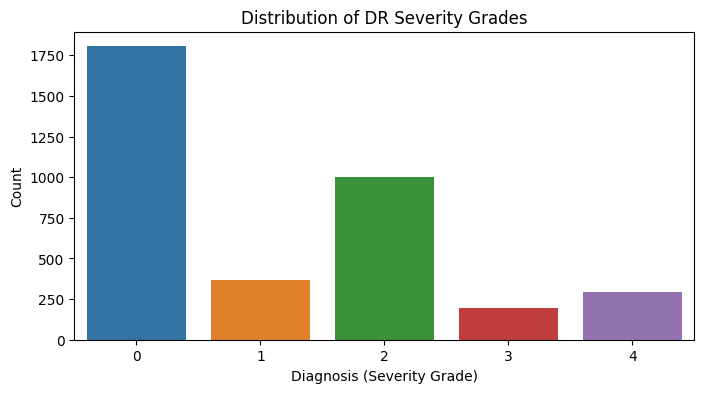

Train set: 2563 images
Validation set: 549 images
Test set: 550 images


In [4]:
# ---
# ## 3. Data Loading and Exploration
# ---
print("Loading train.csv...")
train_df_full = pd.read_csv(train_csv_path)
print(f"Found {len(train_df_full)} entries.")

# Class distribution
diagnosis_counts = train_df_full['diagnosis'].value_counts().sort_index()
plt.figure(figsize=(8,4))
sns.countplot(x='diagnosis', data=train_df_full, order=diagnosis_counts.index)
plt.title('Distribution of DR Severity Grades')
plt.xlabel('Diagnosis (Severity Grade)')
plt.ylabel('Count')
plt.show()

# Stratified split
train_df, temp_df = train_test_split(
    train_df_full, test_size=0.3, random_state=RANDOM_SEED,
    stratify=train_df_full['diagnosis']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=RANDOM_SEED,
    stratify=temp_df['diagnosis']
)
print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.arange(NUM_CLASSES), y=train_df['diagnosis']
)
class_weights_dict = dict(enumerate(class_weights))

In [8]:
# ---
# ## 4. Data Preprocessing
# ---
def apply_clahe_green_channel(image):
    """Apply CLAHE to the green channel."""
    image_np = image.numpy()
    green = image_np[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    green_clahe = clahe.apply(green.astype(np.uint8))
    image_np[:, :, 1] = green_clahe
    return image_np

def preprocess_image(image_path, label, class_weights_dict):
    """Load, preprocess, augment image, and apply class weight."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=CHANNELS)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    
    # Apply CLAHE via tf.py_function
    image = tf.py_function(apply_clahe_green_channel, [image], tf.float32)
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    
    # Normalize to [0,1]
    image = image / 255.0
    
    # Augmentation
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_flip_left_right(image)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    
    # Simulate low-quality images
    if tf.random.uniform(()) > 0.7:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)
    
    # CORAL label encoding
    label = tf.cast(label, tf.int32)
    coral_labels = tf.stack([tf.cast(label > i, tf.float32) for i in range(NUM_ORDINAL_BINS)])
    
    # Assign class weight based on label
    weight = tf.gather(tf.constant(list(class_weights_dict.values()), dtype=tf.float32), label)
    
    return image, coral_labels, weight

def create_dataset(df, img_dir, batch_size, class_weights_dict, shuffle=True):
    """Create tf.data.Dataset with class weights."""
    image_paths = [os.path.join(img_dir, f"{id_code}.png") for id_code in df['id_code']]
    labels = df['diagnosis'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(
        lambda x, y: preprocess_image(x, y, class_weights_dict),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=RANDOM_SEED)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = create_dataset(train_df, train_img_dir, BATCH_SIZE, class_weights_dict)
val_dataset = create_dataset(val_df, train_img_dir, BATCH_SIZE, class_weights_dict, shuffle=False)
test_dataset = create_dataset(test_df, train_img_dir, BATCH_SIZE, class_weights_dict, shuffle=False)

# Distribute datasets
train_dataset = strategy.experimental_distribute_dataset(train_dataset)
val_dataset = strategy.experimental_distribute_dataset(val_dataset)
test_dataset = strategy.experimental_distribute_dataset(test_dataset)

In [10]:
# ---
# ## 5. Model Definition
# ---
def coral_loss(y_true, y_pred, sample_weight=None):
    """CORAL loss for ordinal regression with sample weights."""
    losses = []
    for i in range(NUM_ORDINAL_BINS):
        true_binary = y_true[:, i]
        pred_logit = y_pred[:, i]
        loss = tf.keras.losses.binary_crossentropy(true_binary, pred_logit, from_logits=True)
        if sample_weight is not None:
            loss = loss * sample_weight
        losses.append(loss)
    return tf.reduce_mean(losses)

def coral_rank_accuracy(y_true, y_pred):
    """Accuracy for CORAL predictions."""
    y_pred_rank = tf.reduce_sum(tf.cast(y_pred > 0, tf.int32), axis=1)
    y_true_rank = tf.reduce_sum(tf.cast(y_true > 0.5, tf.int32), axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(y_true_rank, y_pred_rank), tf.float32))

with strategy.scope():
    base_model = applications.EfficientNetB0(
        include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)
    )
    base_model.trainable = False  # Freeze for Stage 1
    
    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_ORDINAL_BINS, activation=None)(x)  # CORAL logits
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=coral_loss,
        metrics=[coral_rank_accuracy]
    )

Epoch 1/15
81/81 - 80s 905ms/step - loss: 0.6349 - coral_rank_accuracy: 0.2143 - val_loss: 0.5747 - val_coral_rank_accuracy: 0.2568 - lr: 1.0000e-03
Epoch 01: val_loss improved from inf to 0.5747, saving model to /kaggle/working/models/retinaguard_best.keras
Epoch 2/15
81/81 - 80s 962ms/step - loss: 0.6037 - coral_rank_accuracy: 0.2578 - val_loss: 0.5658 - val_coral_rank_accuracy: 0.2925 - lr: 1.0000e-03
Epoch 02: val_loss improved from 0.5747 to 0.5658, saving model to /kaggle/working/models/retinaguard_best.keras
Epoch 3/15
81/81 - 80s 836ms/step - loss: 0.5715 - coral_rank_accuracy: 0.2919 - val_loss: 0.5525 - val_coral_rank_accuracy: 0.3246 - lr: 1.0000e-03
Epoch 03: val_loss improved from 0.5658 to 0.5525, saving model to /kaggle/working/models/retinaguard_best.keras
Epoch 4/15
81/81 - 80s 804ms/step - loss: 0.5494 - coral_rank_accuracy: 0.3280 - val_loss: 0.5161 - val_coral_rank_accuracy: 0.3615 - lr: 1.0000e-03
Epoch 04: val_loss improved from 0.5525 to 0.5161, saving model to /

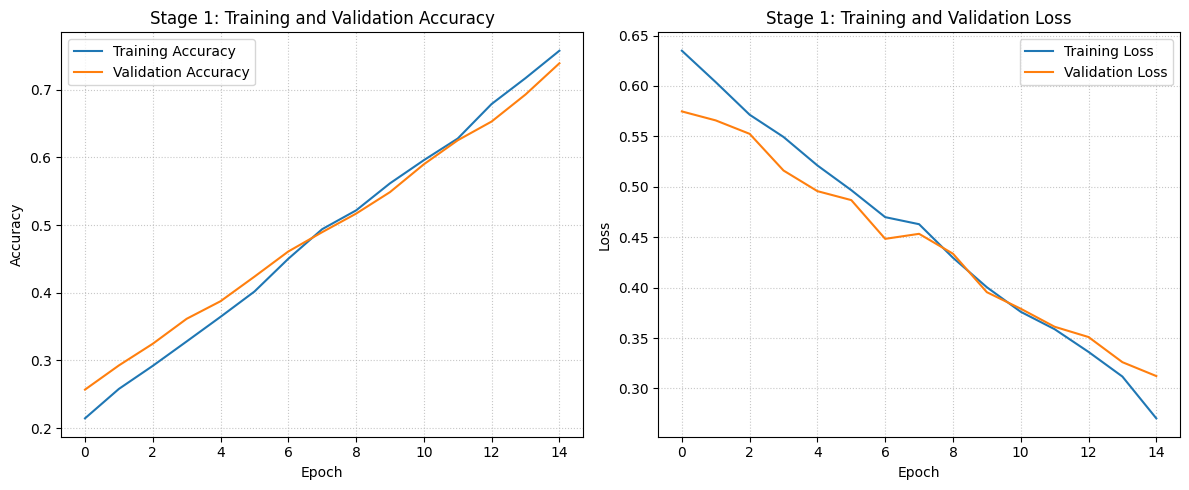

In [8]:
# ---
# ## 6. Stage 1: Head Training
# ---
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        best_model_path, save_best_only=True, monitor='val_loss', mode='min'
    ),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

# Plot Stage 1 history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['coral_rank_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_coral_rank_accuracy'], label='Validation Accuracy')
plt.title('Stage 1: Training and Validation Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Stage 1: Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 16/35
81/81 - 85s 986ms/step - loss: 0.2627 - coral_rank_accuracy: 0.7672 - val_loss: 0.3050 - val_coral_rank_accuracy: 0.7481 - lr: 1.0000e-05
Epoch 16: val_loss improved from 0.3123 to 0.3050, saving model to /kaggle/working/models/retinaguard_best.keras
Epoch 17/35
81/81 - 85s 893ms/step - loss: 0.2554 - coral_rank_accuracy: 0.7784 - val_loss: 0.2975 - val_coral_rank_accuracy: 0.7577 - lr: 1.0000e-05
Epoch 17: val_loss improved from 0.3050 to 0.2975, saving model to /kaggle/working/models/retinaguard_best.keras
Epoch 18/35
81/81 - 85s 987ms/step - loss: 0.2497 - coral_rank_accuracy: 0.7876 - val_loss: 0.2907 - val_coral_rank_accuracy: 0.7703 - lr: 1.0000e-05
Epoch 18: val_loss improved from 0.2975 to 0.2907, saving model to /kaggle/working/models/retinaguard_best.keras
Epoch 19/35
81/81 - 85s 1003ms/step - loss: 0.2421 - coral_rank_accuracy: 0.7991 - val_loss: 0.2815 - val_coral_rank_accuracy: 0.7815 - lr: 1.0000e-05
Epoch 19: val_loss improved from 0.2907 to 0.2815, saving mo

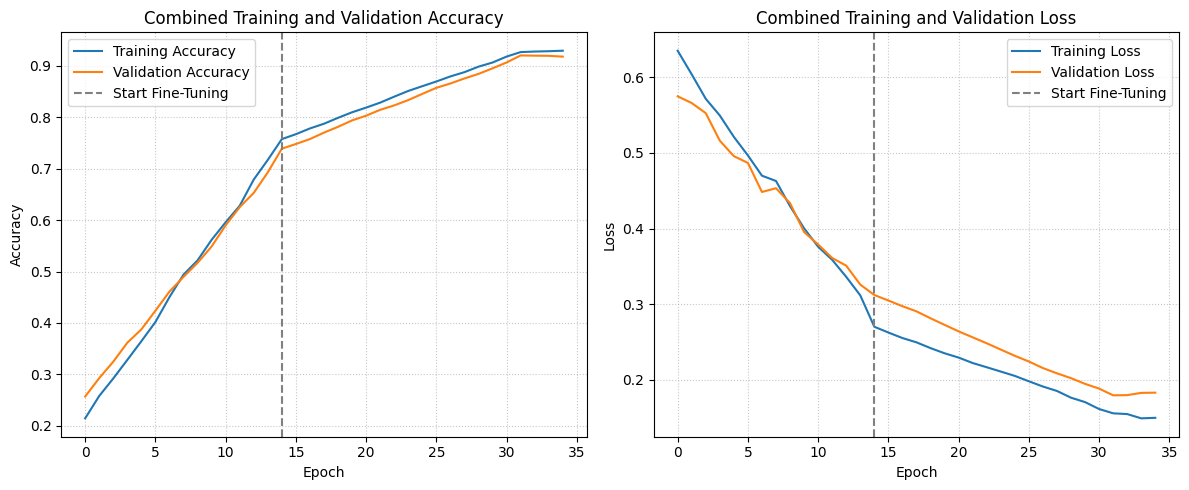

In [9]:
# ---
# ## 7. Stage 2: Fine-Tuning
# ---
with strategy.scope():
    base_model.trainable = True
    for layer in base_model.layers[:100]:  # Freeze early layers
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=coral_loss,
        metrics=[coral_rank_accuracy]
    )

history_fine = model.fit(
    train_dataset,
    epochs=35,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

# Plot combined history
acc = history.history['coral_rank_accuracy'] + history_fine.history['coral_rank_accuracy']
val_acc = history.history['val_coral_rank_accuracy'] + history_fine.history['val_coral_rank_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(len(history.history['loss']), color='grey', linestyle='--', label='Start Fine-Tuning')
plt.title('Combined Training and Validation Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(len(history.history['loss']), color='grey', linestyle='--', label='Start Fine-Tuning')
plt.title('Combined Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()